# Classifying VS from ALeRCE ZTF explorer

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from ASTROMER.models import SingleBandEncoder
from ASTROMER.preprocessing import pretraining_records

2023-08-08 20:14:17.439942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 20:14:17.545786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-08 20:14:17.545804: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-08 20:14:17.575852: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-08 20:14:18.152112: W tensorflow/stream_executor/platform/de

### Loading data

In [2]:
datapath = './data/alcock/fold_0/alcock_100/'

train_batches = pretraining_records(os.path.join(datapath, 'train'),
                                    batch_size=256,
                                    max_obs=200, # all pretrained models are 200-length
                                    shuffle=True,
                                    sampling=True,
                                    repeat=1,
                                    msk_frac=.5,
                                    rnd_frac=.2,
                                    same_frac=.2)
valid_batches = pretraining_records(os.path.join(datapath, 'val'),
                                    batch_size=256,
                                    max_obs=200, # all pretrained models are 200-length
                                    shuffle=True,
                                    sampling=True,
                                    repeat=1,
                                    msk_frac=.5,
                                    rnd_frac=.2,
                                    same_frac=.2)

2023-08-08 20:14:18.991304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-08 20:14:18.991344: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-08 20:14:18.991363: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nosferatu): /proc/driver/nvidia/version does not exist
2023-08-08 20:14:18.991669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-08-08 20:14:20.263067: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


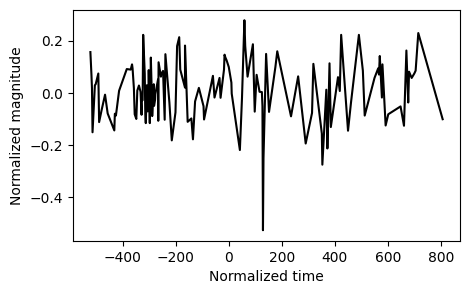

In [3]:
plt.figure(figsize=(5,3), dpi=100)
for batch in train_batches.take(1):
    sample_mags = tf.boolean_mask(batch['input'][0], 1.-batch['mask_in'][0])
    sample_time = tf.boolean_mask(batch['times'][0], 1.-batch['mask_in'][0])
    plt.plot(sample_time, sample_mags, color='k')
    plt.ylabel('Normalized magnitude')
    plt.xlabel('Normalized time')
    break

### Loading Astromer and Finetuning

In [4]:
astromer = SingleBandEncoder()
astromer = astromer.from_pretraining('macho')

[INFO] Weights already downloaded


In [5]:
%%time
astromer.fit(train_batches,
             valid_batches,
             epochs=10,
             patience=20,
             lr=1e-3,
             project_path='./alcock-from-macho',
             verbose=0)

2023-08-08 20:14:22.256957: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/cridonoso/miniconda3/envs/moon/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['output', 'mask_out', 'label', 'id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
EPOCH 9 - ES COUNT: 0.0/20 train mse: 0.1034 - val mse: 0.1444: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

CPU times: user 8min 58s, sys: 2min 39s, total: 11min 38s
Wall time: 1min 26s


### Loading Tf.Record data for classification

In [22]:
num_cls = pd.read_csv(os.path.join(datapath, 'objects.csv')).shape[0]
train_batches = pretraining_records(os.path.join(datapath, 'train'),
                                    batch_size=512,
                                    max_obs=200, # all pretrained models are 200-length
                                    shuffle=True,
                                    sampling=False,
                                    repeat=1,
                                    msk_frac=0.,  # we do not need to exclude elements from attention blocks
                                    rnd_frac=0.,  # we do not need to exclude elements from attention blocks
                                    same_frac=0., # we do not need to exclude elements from attention blocks
                                    n_classes=num_cls) # If n_classes is not None, 
                                                       # it implies that the input should be formatted 
                                                       # for classification.
valid_batches = pretraining_records(os.path.join(datapath, 'val'),
                                    batch_size=512,
                                    max_obs=200,
                                    shuffle=True,
                                    sampling=False,
                                    repeat=1,
                                    msk_frac=0.,
                                    rnd_frac=0.,
                                    same_frac=0.,
                                    n_classes=num_cls)

[INFO] Processing labels
[INFO] Processing labels


### Using encoder to classify (Tensorflow's way)

In [23]:
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model

In [24]:
astromer_encoder = astromer.model.get_layer('encoder')

Astromer encoder is supposed to work on a defined input format. Particularlly, 

- Normalized magnitudes having zero-mean and varying amplitude (do not scale it).
- Normalized timestamps. 
- Attention mask, which is a boolean vector referring to elements that will be excluded from the attention block. Please note that during testing, only padding values will be masked out from the attention mask.  


In [25]:
magnitudes = Input(shape=(200, 1), batch_size=None, name='magnitudes')
times      = Input(shape=(200, 1), batch_size=None, name='times')
mask       = Input(shape=(200, 1), batch_size=None, name='att_mask')
placeholder = {'input':magnitudes, 'mask_in':mask, 'times':times}

Usually, we do not need to retrain Astromer when classifying

In [26]:
astromer_encoder.trainable = False 

Given that the encoder output comprises 200 embeddings, each of size 256, it is necessary to consolidate them to form a singular input.

In our paper, we opted to utilize the mean average of these 200 vectors. In essence, we calculate the average attention across all sequence embeddings.

Assuming the `placeholder` input we can start building our classifier: 

In [27]:
embeddings = astromer_encoder(placeholder, training=False) # double check training encoder

mask = 1.-placeholder['mask_in'] # we need to invert the masking values (Eq.6 Donoso et.al., 2023)
avg_emb = tf.reduce_sum(embeddings*mask , 1)/tf.reduce_sum(mask, 1)

x = Dense(1024, activation='relu')(avg_emb)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = LayerNormalization()(x)
x = Dense(num_cls)(x)

classifier = Model(inputs=placeholder, outputs=x, name="MLP_ATT")

In [28]:
classifier.summary()

Model: "MLP_ATT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 magnitudes (InputLayer)        [(None, 200, 1)]     0           []                               
                                                                                                  
 att_mask (InputLayer)          [(None, 200, 1)]     0           []                               
                                                                                                  
 times (InputLayer)             [(None, 200, 1)]     0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 256)    660736      ['magnitudes[0][0]',             
                                                                  'att_mask[0][0]',         

We need to compile the classifier by passing a `loss` function, `metrics`, and `optimizer`

In [29]:
classifier.compile(loss=CategoricalCrossentropy(from_logits=True), 
                   metrics='accuracy',
                   optimizer=Adam(1e-3))

then we start training

In [31]:
history = classifier.fit(train_batches, 
                         epochs=20, 
                         validation_data=valid_batches,
                         callbacks=[EarlyStopping(patience=10)])

Epoch 1/20
4/4 [==============================] - 17s 4s/step - loss: 3.1258 - accuracy: 0.1870 - val_loss: 2.3625 - val_accuracy: 0.1973
Epoch 2/20
4/4 [==============================] - 15s 4s/step - loss: 2.1178 - accuracy: 0.1556 - val_loss: 1.8689 - val_accuracy: 0.1929
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 1.9004 - accuracy: 0.1931 - val_loss: 1.8176 - val_accuracy: 0.1840
Epoch 4/20
4/4 [==============================] - 15s 4s/step - loss: 1.7764 - accuracy: 0.2458 - val_loss: 1.8238 - val_accuracy: 0.1973
Epoch 5/20
4/4 [==============================] - 16s 4s/step - loss: 1.8256 - accuracy: 0.1860 - val_loss: 1.7815 - val_accuracy: 0.2018
Epoch 6/20
4/4 [==============================] - 15s 4s/step - loss: 1.7821 - accuracy: 0.2387 - val_loss: 1.7736 - val_accuracy: 0.1929
Epoch 7/20
4/4 [==============================] - 15s 4s/step - loss: 1.7707 - accuracy: 0.2032 - val_loss: 1.7720 - val_accuracy: 0.2550
Epoch 8/20
4/4 [==================

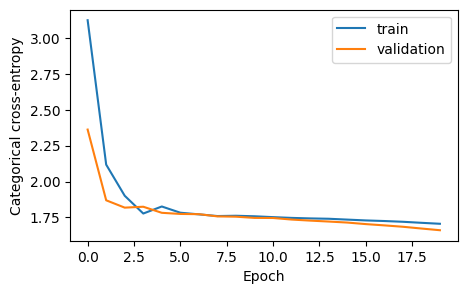

In [72]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epoch')
plt.show()

### Testing

In [33]:
from ASTROMER.core.plots import plot_cm
from sklearn.metrics import confusion_matrix

In [45]:
test_batches = pretraining_records(os.path.join(datapath, 'test'),
                                   batch_size=512,
                                   max_obs=200,
                                   shuffle=False,
                                   sampling=True,
                                   repeat=1,
                                   msk_frac=0.,
                                   rnd_frac=0.,
                                   same_frac=0.,
                                   n_classes=num_cls)

[INFO] Processing labels


In [64]:
classifier.evaluate(test_batches)

8/8 [==============================] - 23s 3s/step - loss: 1.7509 - accuracy: 0.2869


[1.7508866786956787, 0.2869444489479065]